# Fine-tune BLIP using Hugging Face `transformers`, `datasets`, `peft` 🤗 and `bitsandbytes`

In [1]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class TweetImageTextDataset(Dataset):
    def __init__(self, csv_path, image_dir):
        self.data = pd.read_csv(csv_path).dropna(subset=["txt", "new_image_id"])
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_dir, row["new_image_id"])
        image = Image.open(image_path).convert("RGB")  # 保留为 PIL.Image

        return {
            "text": row["txt"],
            "image": image
        }

In [15]:
dataset = TweetImageTextDataset("data/train.csv", "data/image")
dataset[1]["text"]   # 输出文本

'RT @ 9NEWS : # BREAKING : Police release sketch of vehicle of interest in northern CO shootings . Tip line : 970 - 498 - 5595'

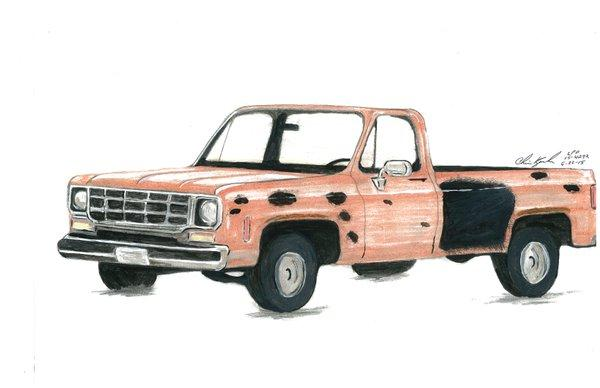

In [16]:
dataset[1]["image"]  # 输出图像 Tensor 形状 (3, H, W)

## Create PyTorch Dataset

Let's define below the dataset as well as the data collator!

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


## Load model and processor

In [5]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BitsAndBytesConfig

quant_config = BitsAndBytesConfig(load_in_8bit=True)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", quantization_config=quant_config)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [6]:
from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.1398


Now that we have loaded the processor, let's load the dataset and the dataloader:

In [7]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16, collate_fn=collate_fn)

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [8]:
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()

for epoch in range(20):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0


Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.


Loss: 6.70703125
Loss: 6.4453125
Loss: 6.72265625
Loss: 6.3125
Loss: 6.02734375
Loss: 5.16015625
Loss: 4.62890625
Loss: 4.72265625
Loss: 4.76953125
Loss: 4.5625
Loss: 4.39453125
Loss: 4.8125
Loss: 4.39453125
Loss: 4.359375
Loss: 4.2890625
Loss: 4.24609375
Loss: 3.822265625
Loss: 3.939453125
Loss: 3.8203125
Loss: 3.48828125
Loss: 3.974609375
Loss: 3.509765625
Loss: 3.701171875
Loss: 3.708984375
Loss: 3.728515625
Loss: 3.826171875
Loss: 3.3203125
Loss: 3.23828125
Loss: 3.77734375
Loss: 3.091796875
Loss: 3.55078125
Loss: 3.19921875
Loss: 3.458984375
Loss: 3.146484375
Loss: 3.19921875
Loss: 3.224609375
Loss: 3.494140625
Loss: 3.392578125
Loss: 2.775390625
Loss: 3.37890625
Loss: 2.916015625
Loss: 4.203125
Loss: 3.0625
Loss: 2.84375
Loss: 2.921875
Loss: 2.734375
Loss: 3.45703125
Loss: 2.880859375
Loss: 3.421875
Loss: 3.138671875
Loss: 2.607421875
Loss: 3.103515625
Loss: 2.984375
Loss: 2.779296875
Loss: 3.017578125
Loss: 3.1484375
Loss: 2.630859375
Loss: 2.55078125
Loss: 2.642578125
Loss: 3.1

In [9]:
model.save_pretrained("blip2-finetuned")

## Inference

Let's check the results on our train dataset

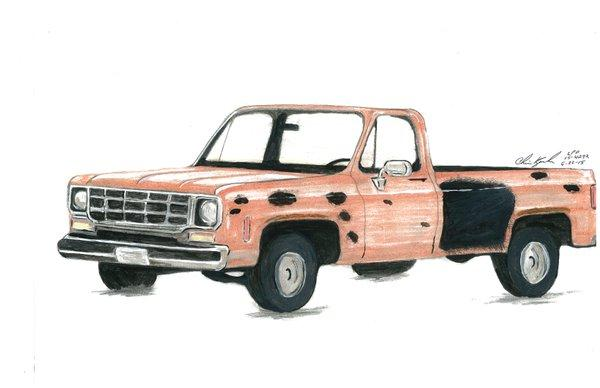

In [12]:
# load image
example = dataset[1]
image = example["image"]
image

In [13]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

RT @ History Pics : 1970 - 1972 Ford F-250 & Gm Gm Gm Gm
